In [1]:
import kagglehub
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2


In [2]:
# Download latest version
dataset_path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", dataset_path)

100%|██████████| 586M/586M [00:05<00:00, 118MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2


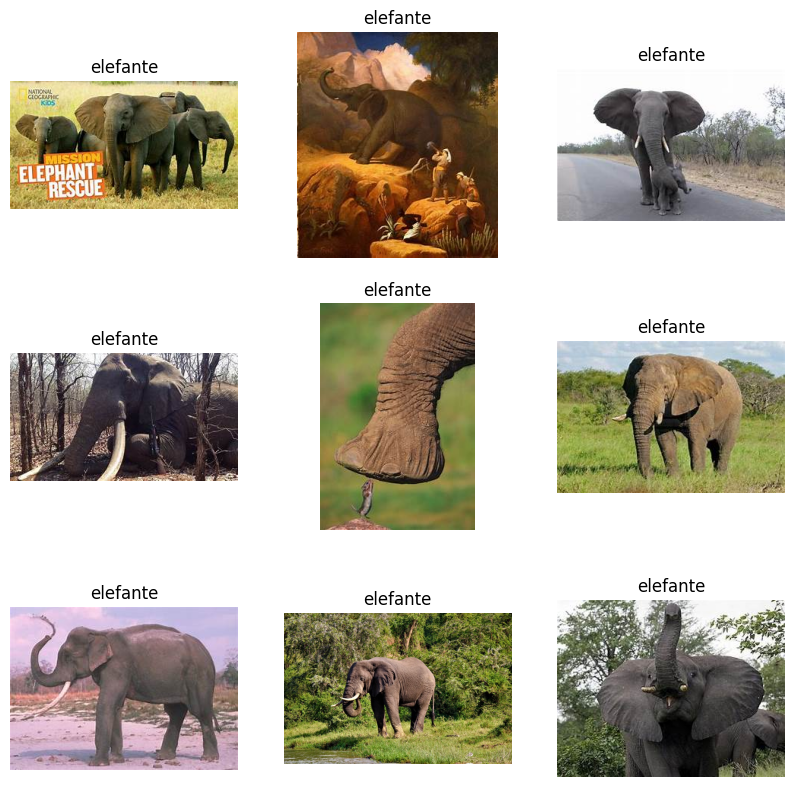

In [3]:
image_folder = os.path.join(dataset_path, "raw-img")

class_name = os.listdir(image_folder)[4]
class_path = os.path.join(image_folder, class_name)


image_files = os.listdir(class_path)[:9]

plt.figure(figsize=(10, 10))
for i, img_file in enumerate(image_files):
    img_path = os.path.join(class_path, img_file)
    img = Image.open(img_path)

    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(class_name)

plt.show()

In [4]:
image_paths = []  # List to store full paths of all images
labels = []       # List to store numeric labels corresponding to each image
classes = []      # List to store class names (folder names)

dataset_path = "/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/raw-img"

# Get the names of all folders inside the dataset directory (each folder represents a class)
classes = os.listdir(dataset_path)

# Iterate through all class folders in the dataset path
for label, class_name in enumerate(classes):
    class_folder = os.path.join(dataset_path, class_name)

    # Iterate through all images inside the class folder
    for image_file in os.listdir(class_folder):
        image_paths.append(os.path.join(class_folder, image_file))
        labels.append(label)

# Read one image to know it is shape
sample_image = cv2.imread(image_paths[3]) # deferent shapes for deferent images so we need resize it
height, width, channels = sample_image.shape

print(f"Number of images: {len(image_paths)}")
print(f"Image size: {height}x{width}, Channels: {channels}")

Number of images: 26179
Image size: 205x300, Channels: 3


In [5]:
# 1. Load dataset filenames and labels

classes = [c for c in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, c))]  # Filter only directories

all_filenames = []
all_labels = []

for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    filenames = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]  # Filter image files
    all_filenames.extend([os.path.join(class_name, fname) for fname in filenames])
    all_labels.extend([class_name] * len(filenames))  # Keep class as a string

# 2. Split filenames into train and validation sets
train_files, val_files, train_labels, val_labels = train_test_split(
    all_filenames, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

# 3. Create ImageDataGenerator with Augmentations for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize images
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Normalize validation images

# 4. Create DataFrames for Train and Validation
train_df = pd.DataFrame({'filename': train_files, 'class': train_labels})
val_df = pd.DataFrame({'filename': val_files, 'class': val_labels})

# 5. Create Data Generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=dataset_path,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=dataset_path,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 20943 validated image filenames belonging to 10 classes.
Found 5236 validated image filenames belonging to 10 classes.


In [6]:
def load_data(data_dir, img_size=(224, 224), batch_size=32):
    train_ds = keras.preprocessing.image_dataset_from_directory(
        data_dir, validation_split=0.2, subset="training", seed=123,
        image_size=img_size, batch_size=batch_size)

    test_ds = keras.preprocessing.image_dataset_from_directory(
        data_dir, validation_split=0.2, subset="validation", seed=123,
        image_size=img_size, batch_size=batch_size)

    class_names = train_ds.class_names
    return train_ds, test_ds, len(class_names)

def build_model(model_name, num_classes):
    if model_name == 'resnet':
        base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'efficientnet':
        base_model = keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'inception':
        base_model = keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    else:
        raise ValueError("Model not supported")

    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, train_ds, val_ds, num_epochs= 5):
    history = model.fit(train_ds, validation_data=val_ds, epochs=num_epochs)
    return history

train_ds, val_ds, num_classes = load_data(dataset_path)
print("Class names from dataset:", train_ds.class_names)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.
Class names from dataset: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [7]:
# resnet_model = build_model("resnet", num_classes)
# train_model(resnet_model, train_ds, val_ds)
# print("=" * 100)
efficientnet_model = build_model("efficientnet", num_classes)
train_model(efficientnet_model, train_ds, val_ds)
print("=" * 100)
# inception_model = build_model("inception", num_classes)
# train_model(inception_model, train_ds, val_ds)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 92s 94ms/step - accuracy: 0.9076 - loss: 0.3321 - val_accuracy: 0.9759 - val_loss: 0.0854
Epoch 2/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.9784 - loss: 0.0786 - val_accuracy: 0.9771 - val_loss: 0.0826
Epoch 3/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - accuracy: 0.9831 - loss: 0.0553 - val_accuracy: 0.9752 - val_loss: 0.0822
Epoch 4/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.9865 - loss: 0.0460 - val_accuracy: 0.9784 - val_loss: 0.0808
Epoch 5/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 37s 56ms/step - accuracy: 0.9893 - loss: 0.0370 - val_accuracy: 0.9784 - val_loss: 0.0849


In [8]:

efficientnet_model.save('efficientnet_model.h5')

In [9]:
from collections import Counter
print(Counter(train_labels))


Counter({'cane': 3890, 'ragno': 3857, 'gallina': 2478, 'cavallo': 2098, 'farfalla': 1690, 'mucca': 1493, 'scoiattolo': 1490, 'pecora': 1456, 'gatto': 1334, 'elefante': 1157})


In [12]:
def evaluate_model(model, model_name, test_ds):
    print(f"Evaluating Model: {model_name}\n" + "-"*50)

    # Get true labels and images
    y_true = []
    X_test = []

    for images, labels in test_ds:
        X_test.append(images.numpy())  # Convert images to numpy array
        y_true.append(labels.numpy())  # Convert labels to numpy array

    X_test = np.concatenate(X_test, axis=0)
    y_true = np.concatenate(y_true, axis=0)

    # Predict the labels
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='macro')
    recall = recall_score(y_true, y_pred_classes, average='macro')
    f1 = f1_score(y_true, y_pred_classes, average='macro')

    # Print evaluation results
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Print full classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred_classes))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(np.unique(y_true))), yticklabels=range(len(np.unique(y_true))))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


Evaluating Model: efficientnet model
--------------------------------------------------
164/164 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step
Accuracy: 0.9784
Precision: 0.9767
Recall: 0.9753
F1 Score: 0.9760
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       947
           1       0.97      0.97      0.97       522
           2       0.99      0.98      0.99       273
           3       0.98      0.99      0.98       429
           4       0.98      0.99      0.99       593
           5       0.97      0.97      0.97       331
           6       0.94      0.96      0.95       399
           7       0.98      0.94      0.96       382
           8       0.99      0.99      0.99       979
           9       0.98      0.98      0.98       380

    accuracy                           0.98      5235
   macro avg       0.98      0.98      0.98      5235
weighted avg       0.98      0.98      0.98      5235



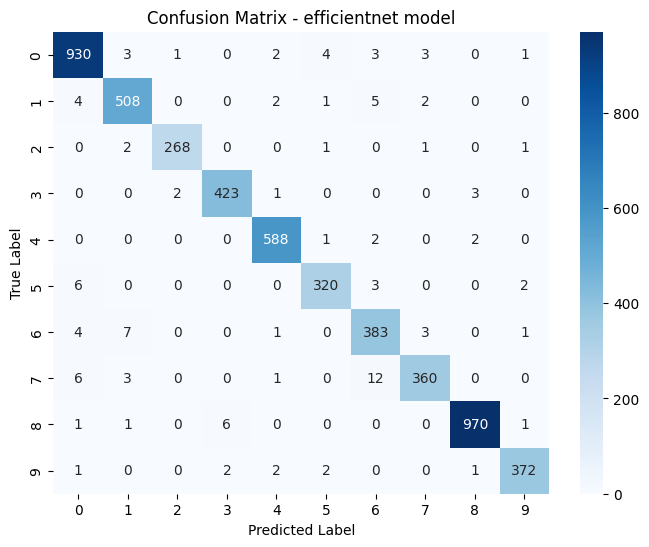

In [14]:
# Evaluate all models
#evaluate_model(resnet_model,  "resnet model", val_ds)
evaluate_model(efficientnet_model, "efficientnet model", val_ds)
#evaluate_model(inception_model, "inception model", val_ds)

In [18]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files

try:
    model = tf.keras.models.load_model("/content/efficientnet_model.h5")
    print(" Model loaded successfully!")
except Exception as e:
    print("Error loading model:", e)


 Model loaded successfully!


In [19]:
uploaded = files.upload()

Saving efficientnet_model3.h5 to efficientnet_model3.h5


Saving EasternGraySquirrel_GAm.jpg to EasternGraySquirrel_GAm.jpg
Loaded image: EasternGraySquirrel_GAm.jpg


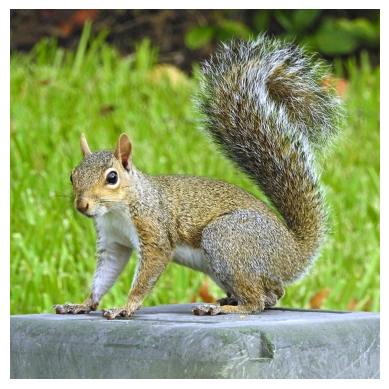

In [32]:

uploaded = files.upload()

image_path = list(uploaded.keys())[0]
print("Loaded image:", image_path)

image = Image.open(image_path)
plt.imshow(image)
plt.axis("off")
plt.show()


In [33]:

def preprocess_image(image):
    image = image.resize((224, 224))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    return image

processed_image = preprocess_image(image)


In [34]:

predictions = model.predict(processed_image)

predicted_class = np.argmax(predictions)
confidence = np.max(predictions) * 100

print(f" Prediction: Class {predicted_class}")
print(f" Confidence: {confidence:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
 Prediction: Class 0
 Confidence: 16.32%


In [35]:
predictions

array([[0.16323446, 0.07976421, 0.09641046, 0.11259525, 0.10014436,
        0.07892123, 0.04485686, 0.07815994, 0.1023641 , 0.14354917]],
      dtype=float32)